In [3]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import os
import scipy.signal as sgn
from tqdm import tqdm
from biosppy.signals import ecg
from scipy.interpolate import CubicSpline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from scipy.signal import cheby1, filtfilt, medfilt, decimate
import tensorflow as tf
import pywt
import matplotlib.colors as mcolors
import shutil
from scipy.signal import butter, filtfilt
from multiprocessing import Pool, cpu_count

In [4]:
# get the list of files to be processed
ecgs_df = pd.read_csv("1.0.0\\list", header=None, names=['id'])
# add filepaths so we can retrieve the files later on
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: str("apnea-ecg\\1.0.0\\" + x))
# divide the dataset into train and test dataset as per instrucctions in the data set
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

In [5]:
# display the first 5 entries
ecgs_df.head()

,id,filepath,dataset
0,a01,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
1,a02,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
2,a03,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
3,a04,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train
4,a05,C:\Users\abbas\BAU\11Fall 2024\FYP2\apnea-ecg\...,train


In [6]:
# display number of training and testing samples
freq = ecgs_df['dataset'].value_counts()
print(freq)

train    35
test     35
Name: dataset, dtype: int64


In [7]:
# Function to apply bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [8]:
# Function to load ECG and preprocess it
def load_ecg(file):
    # Load the ECG signal
    record = wfdb.rdrecord(file)

    # Load the annotation
    annotation = wfdb.rdann(file, extension="apn")

    # Extract the signal
    p_signal = record.p_signal

    # Extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [9]:
# Function to apply CWT to the ECG signal and convert to a spectrogram
def apply_cwt(signal, wavelet='morl', scales=np.arange(5, 60)):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet)
    power = np.abs(coeffs) ** 2  # Power of the CWT coefficients
    return power


In [10]:
def save_cwt_as_image(cwt_spectrogram, filename):
    plt.figure(figsize=(6, 3))
    plt.imshow(cwt_spectrogram, aspect='auto', cmap='jet', norm=mcolors.Normalize(vmin=0, vmax=0.5))
    plt.grid(False)
    plt.axis('off')  # Remove grid and axis
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight', pad_inches=0)
    plt.close()

In [11]:
# Split into training and test set as per instructions
train_ecg_paths = ecgs_df[ecgs_df['dataset'] == 'train']['filepath'].tolist()
test_ecg_paths = ecgs_df[ecgs_df['dataset'] == 'test']['filepath'].tolist()


In [12]:
# Extract labels from annotation file
def extract_labels(file):
    annotation = wfdb.rdann(file, extension='apn')
    labels = annotation.symbol
    label_map = {'A': 1, 'N': 0}
    return [label_map[symbol] for symbol in labels]

In [13]:
# Function to organize and generate CWT images into class directories
def generate_and_organize_cwt_images(pts, num_sec, fs, save_dir):
    for pt in pts:
        base_filename = os.path.basename(pt).split('.')[0]
        # Check if the image already exists
        filename = f"{save_dir}/ecg_image_{base_filename}_0.png"
        if os.path.exists(filename):
            print(f"File {filename} already exists, skipping {pt}.")
            continue
        
        p_signal, atr_sym, atr_sample = load_ecg(pt)
        
        for i, sample in enumerate(atr_sample):
            label = atr_sym[i]
            start_idx = max(0, sample - num_sec * fs)
            end_idx = min(len(p_signal), sample + num_sec * fs)
            signal_segment = p_signal[start_idx:end_idx]

            # Apply bandpass filter to the signal segment
            filtered_signal_segment = bandpass_filter(signal_segment, lowcut=0.5, highcut=40, fs=fs)

            # Apply CWT and generate the spectrogram
            cwt_spectrogram = apply_cwt(filtered_signal_segment)

            # Define the filename and save the image
            filename = f"{save_dir}/ecg_image_{base_filename}_{i}.png"

            if os.path.exists(filename):
                print(f"File {filename} already exists, skipping.")
                continue

            save_cwt_as_image(cwt_spectrogram, filename)
            print(f"Saved {filename}")

            # Move the image to the appropriate class directory (0 for normal, 1 for apnea)
            label_dir = '1' if label == 'A' else '0'
            target_dir = os.path.join(save_dir, label_dir)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)

            dest = os.path.join(target_dir, f"ecg_image_{base_filename}_{i}.png")
            shutil.move(filename, dest)
            print(f"Moved {filename} to {target_dir}")

In [19]:

def plot_cwt_spectrogram(signal_segment, wavelet='morl', scales=np.linspace(5, 100, 150)):
    # Apply CWT
    coef, freqs = pywt.cwt(signal_segment, scales=scales, wavelet=wavelet)

    # Normalize CWT coefficients
    norm_coef = np.abs(coef) / np.max(np.abs(coef))

    # Plot CWT spectrogram with improved scaling
    plt.figure(figsize=(12, 8))
    plt.imshow(norm_coef, extent=[0, len(signal_segment), np.min(scales), np.max(scales)],
               cmap='jet', aspect='auto', interpolation='bilinear', vmin=0, vmax=0.5)
    plt.colorbar(label='Normalized Amplitude')
    plt.title(f'CWT Spectrogram with {wavelet} wavelet')
    plt.xlabel('Samples')
    plt.ylabel('Scales')
    plt.show()

    # Plot raw ECG signal
    plt.figure(figsize=(10, 4))
    plt.plot(signal_segment)
    plt.title('Raw ECG Segment (Filtered and Normalized)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()


# Example usage
filepath = "C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/a01"
fs = 100  # Sampling frequency of the ECG signal
signal_segment = load_and_preprocess_ecg(filepath, num_sec=10, fs=fs)
plot_cwt_spectrogram(signal_segment, wavelet='morl')


NameError: name 'load_and_preprocess_ecg' is not defined

In [14]:
# Set directories
train_image_dir = 'train_set'
test_image_dir = 'test_set'

In [ ]:
# Train ECG paths
train_ecg_paths = []
for i in range(1, 21):
    train_ecg_paths.append(f"apnea-ecg/1.0.0/a{str(i).zfill(2)}")
for i in range(1, 6):
    train_ecg_paths.append(f"apnea-ecg/1.0.0/b{str(i).zfill(2)}")
for i in range(1, 11):
    train_ecg_paths.append(f"apnea-ecg/1.0.0/c{str(i).zfill(2)}")

# Test ECG paths
test_ecg_paths = []
for i in range(1, 36):
    test_ecg_paths.append(f"1.0.0/x{str(i).zfill(2)}")

# Ensure the save directories exist
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)


# Generate and organize CWT spectrogram images for training and testing sets
#generate_and_organize_cwt_images(train_ecg_paths, num_sec=10, fs=100, save_dir=train_image_dir)
generate_and_organize_cwt_images(test_ecg_paths, num_sec=10, fs=100, save_dir=test_image_dir)



In [53]:
from keras import models, layers, optimizers, regularizers
from tensorflow_addons.optimizers import AdamW

def build_cnn_lstm_model(input_shape):
    model = models.Sequential()

    # Conv2D layers to extract spatial features from images
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, 
                            kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))  # Slightly increased Dropout

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', 
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', 
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    # Additional Conv2D layer for deeper feature extraction
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', 
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.6))

    # Flatten the data before feeding into LSTM
    model.add(layers.Flatten())

    # LSTM layers to process temporal dependencies
    model.add(layers.RepeatVector(1))
    model.add(layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.LSTM(128, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))

    # Fully Connected Layer with L2 regularization
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.6))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model using AdamW Optimizer with Gradient Clipping
    optimizer = AdamW(learning_rate=0.0003, weight_decay=1e-6, clipnorm=1.0)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [54]:
# Set image input shape (height, width, channels)
input_shape = (128, 128, 3) 

# Build the CNN-LSTM model
model = build_cnn_lstm_model(input_shape)

# Print the model summary
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_29 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_53 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_30 (Ba  (None, 61, 61, 64)       

In [55]:
# Define the model checkpoint
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

from keras.preprocessing.image import ImageDataGenerator

# Set paths for the updated train and validation directories
train_new_dir = 'ecg-spec3/train_new'
validation_dir = 'ecg-spec3/validation'

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2]
)

# Train generator from new training directory
train_generator = train_datagen.flow_from_directory(
    train_new_dir,
    target_size=(128, 128),  # Adjust to your model input size
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

# Validation generator from the new validation directory
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),  # Adjust to your model input size
    batch_size=64,
    class_mode='binary',
    shuffle=True  # Ensure validation set is shuffled
)

# Test generator (remain unchanged, as this directory was not modified)
test_image_dir = 'ecg-spec3/test_set'
test_generator = val_datagen.flow_from_directory(
    test_image_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

# Now, you can continue using these generators in model training


Found 13611 images belonging to 2 classes.
Found 3433 images belonging to 2 classes.
Found 17268 images belonging to 2 classes.


In [56]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/25
213/213 [==============================] - ETA: 0s - loss: 2.1948 - accuracy: 0.5231
Epoch 1: val_loss improved from inf to 1.73601, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3\best_model.h5
213/213 [==============================] - 360s 2s/step - loss: 2.1948 - accuracy: 0.5231 - val_loss: 1.7360 - val_accuracy: 0.3822 - lr: 3.0000e-04
Epoch 2/25


C:\Users\abbas\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 [==============================] - ETA: 0s - loss: 1.4653 - accuracy: 0.5557
Epoch 2: val_loss improved from 1.73601 to 1.32296, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3\best_model.h5
213/213 [==============================] - 343s 2s/step - loss: 1.4653 - accuracy: 0.5557 - val_loss: 1.3230 - val_accuracy: 0.3822 - lr: 3.0000e-04
Epoch 3/25
213/213 [==============================] - ETA: 0s - loss: 1.1413 - accuracy: 0.6338
Epoch 3: val_loss improved from 1.32296 to 1.15008, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apnea-ecg/1.0.0/Model_CheckPoint_draft_3\best_model.h5
213/213 [==============================] - 349s 2s/step - loss: 1.1413 - accuracy: 0.6338 - val_loss: 1.1501 - val_accuracy: 0.5669 - lr: 3.0000e-04
Epoch 4/25
213/213 [==============================] - ETA: 0s - loss: 1.0194 - accuracy: 0.6894
Epoch 4: val_loss improved from 1.15008 to 1.06018, saving model to C:/Users/abbas/BAU/11Fall 2024/FYP2/apn

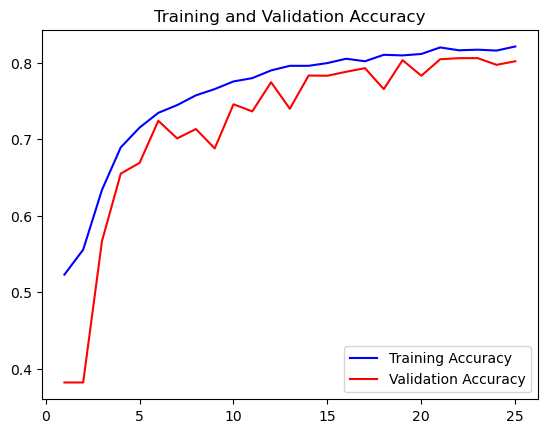

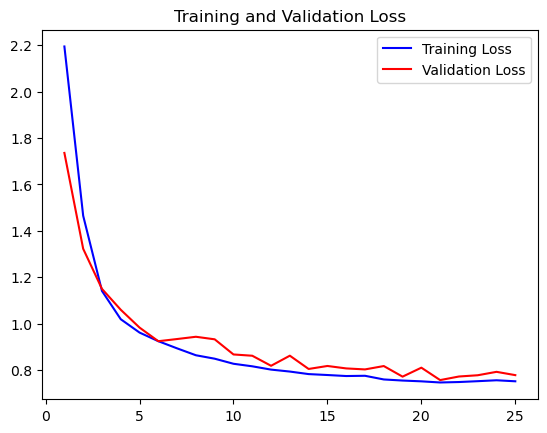

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure()
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()